In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
orig_data = pd.read_csv("./../data/precool/2023_04_03.csv")
orig_data.head()

,temperature,humidity,airflow,openness,Q
0,33.39,19.205509,43,99.80,1429.082319
1,33.32,19.124645,43,99.80,1426.344491
2,33.35,19.327249,43,99.82,1442.030630
3,33.37,19.291903,43,99.81,1437.702476
4,33.56,19.360556,43,99.82,1457.806304


In [3]:
data = orig_data.copy()
data.shape

(133746, 5)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133746 entries, 0 to 133745
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  133746 non-null  float64
 1   humidity     133746 non-null  float64
 2   airflow      133746 non-null  int64  
 3   openness     133746 non-null  float64
 4   Q            133746 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 5.1 MB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,133746.0,21.921990,9.816176,0.100000,11.410000,24.040000,29.960000,39.630000
humidity,133746.0,12.844572,6.134533,2.608454,6.141227,14.013472,18.081281,25.438419
airflow,133746.0,43.000000,0.000000,43.000000,43.000000,43.000000,43.000000,43.000000
openness,133746.0,60.107921,45.672561,0.290000,0.320000,99.800000,99.830000,99.830000
Q,133746.0,698.333743,613.351936,0.000000,0.000000,770.822826,1317.943640,1902.024648


No missing values, all numeric

In [7]:
#Changing column headers to just keep component names
data.columns = [col[:col.find("(")].strip() for col in data.columns]
data.head()

,temperatu,humidi,airfl,openne,
0,33.39,19.205509,43,99.80,1429.082319
1,33.32,19.124645,43,99.80,1426.344491
2,33.35,19.327249,43,99.82,1442.030630
3,33.37,19.291903,43,99.81,1437.702476
4,33.56,19.360556,43,99.82,1457.806304


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data[data.columns[:-1]],
                                                    data[[data.columns[-1]]],
                                                    test_size = .2,
                                                    random_state = 1)

Rather than splitting training data further to validation set, we will perform cross validation in all our training models.

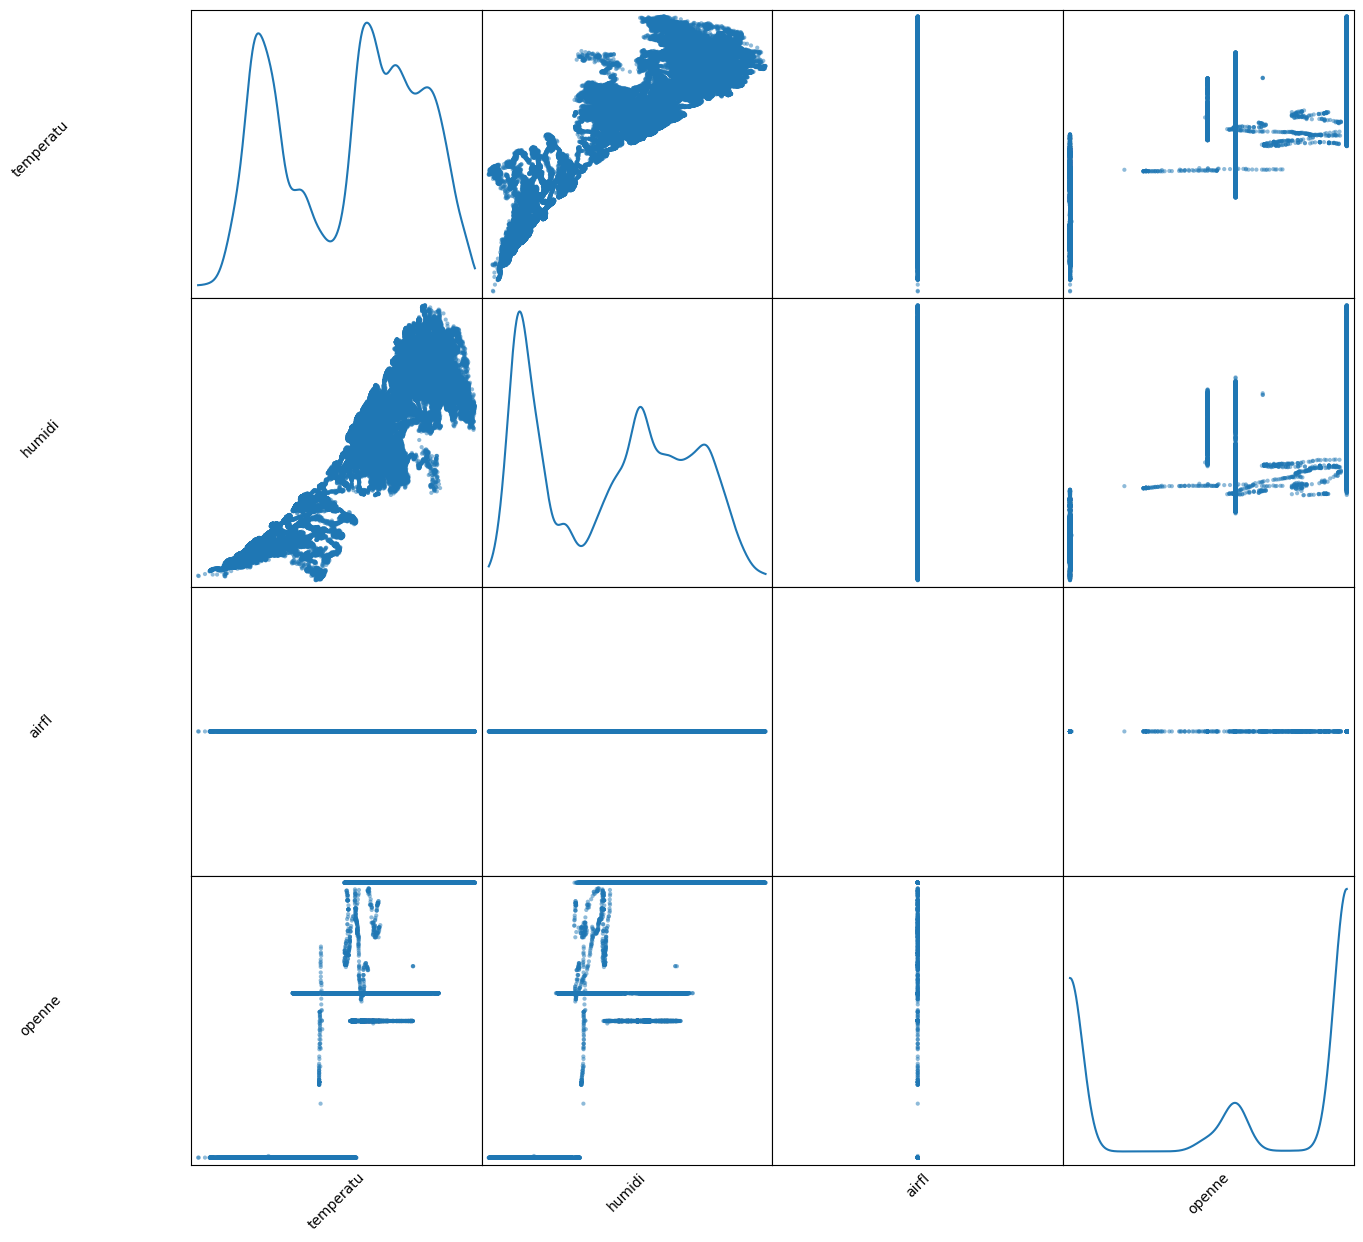

In [9]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
sm = scatter_matrix(x_train, figsize=(15,15), diagonal = 'kde')
#Changing label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(45) for s in sm.reshape(-1)]
#Changing offset for label
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]
#Hiding ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]
plt.show()

No high correlation between any two features. Lets verify with Heatmap.

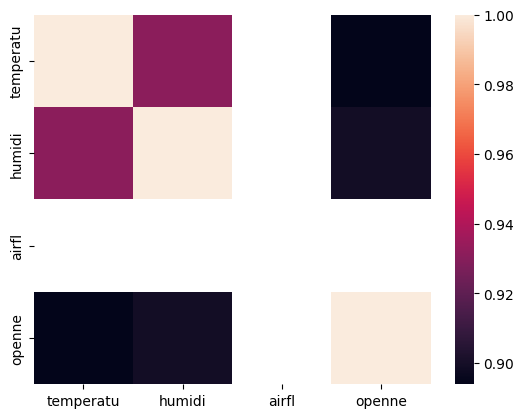

In [10]:
import seaborn as sns
sns.heatmap(x_train.corr().abs())
plt.show()

Little correlation of ~0.6 between Superplasticizer and Water (which is negative as evident from scatter matrix), but lets move forward as is.

In [11]:
#Scaling the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train),
                              columns = x_train.columns)
x_train_scaled.head()

,temperatu,humidi,airfl,openne
0,1.406021,0.692435,0.0,0.870952
1,-0.729119,-1.036692,0.0,-1.306808
2,1.232681,1.182805,0.0,0.871609
3,0.542380,0.153267,0.0,0.871609
4,-1.284826,-1.289337,0.0,-1.306808


In [13]:
#We will save the model performance metrics in a DataFrame
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
Model = []
RMSE = []
R_sq = []
cv = KFold(5, random_state = 1, shuffle = True)

#Creating a Function to append the cross validation scores of the algorithms
def input_scores(name, model, x, y):
    Model.append(name)
    RMSE.append(np.sqrt((-1) * cross_val_score(model, x, y, cv=cv, 
                                               scoring='neg_mean_squared_error').mean()))
    R_sq.append(cross_val_score(model, x, y, cv=cv, scoring='r2').mean())

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)

names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression',
         'K Neighbors Regressor', 'Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor']
models = [LinearRegression(), Ridge(), Lasso(),
          KNeighborsRegressor(), DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor()]

#Running all algorithms
for name, model in zip(names, models):
    input_scores(name, model, x_train_scaled, y_train)

In [23]:
evaluation = pd.DataFrame({'Model': Model,
                           'RMSE': RMSE,
                           'R Squared': R_sq})
print("FOLLOWING ARE THE TRAINING SCORES: ")
evaluation

FOLLOWING ARE THE TRAINING SCORES: 


,Model,RMSE,R Squared
0,Linear Regression,115.098226,0.964764
1,Ridge Regression,115.098227,0.964764
2,Lasso Regression,115.102834,0.964761
3,K Neighbors Regressor,17.532633,0.999182
4,Decision Tree Regressor,22.132663,0.998698
5,Random Forest Regressor,17.235095,0.999211
6,Gradient Boosting Regressor,24.957544,0.998343
7,Adaboost Regressor,53.832195,0.992543


Gradient Boosting Regressor has the lowest RMSE, highest R-Squared

In [25]:
#tuning this base model
RandomForestRegressor()

RandomForestRegressor()

In [31]:
#tuning for number of trees
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':range(20,1001,100),
              'max_depth':[10], #range(5,16,2), 
              'min_samples_split':[1000]} #range(200,1001,200)
clf = GridSearchCV(RandomForestRegressor(random_state = 1), 
                   param_grid = param_grid, scoring='r2', 
                   cv = cv).fit(x_train_scaled, y_train)
print(clf.best_estimator_) 
print("R Squared:",clf.best_score_)

RandomForestRegressor(max_depth=10, min_samples_split=1000, n_estimators=320,
                      random_state=1)
R Squared: 0.9974357621167146


In [33]:
#tuning the tree specific parameters
param_grid = {'n_estimators': [320],
              'max_depth': range(10,31,2), 
              'min_samples_split': [1000]}
clf = GridSearchCV(RandomForestRegressor(random_state=1), 
                   param_grid = param_grid, scoring='r2', 
                   cv=cv).fit(x_train_scaled, y_train)
print(clf.best_estimator_) 
print("R Squared:",clf.best_score_)

RandomForestRegressor(max_depth=14, min_samples_split=1000, n_estimators=320,
                      random_state=1)
R Squared: 0.9974408630593711


In [34]:
#tuning the tree specific parameters
param_grid = {'n_estimators': [320],
              'max_depth': [14], 
              'min_samples_split': range(1000, 6000, 100)}
clf = GridSearchCV(RandomForestRegressor(random_state=1), 
                   param_grid = param_grid, scoring='r2', 
                   cv=cv).fit(x_train_scaled, y_train)
print(clf.best_estimator_) 
print("R Squared:",clf.best_score_)

RandomForestRegressor(max_depth=14, min_samples_split=1000, n_estimators=320,
                      random_state=1)
R Squared: 0.9974408630593711


**Since score improved, the best model is GradientBoostingRegressor with learning_rate= 0.2/2, max_depth= 20, min_samples_split= 170, n_estimators= 230*2**

In [40]:
#applying this model on test data
x_test_scaled = pd.DataFrame(scaler.transform(x_test),
                             columns = x_test.columns)
clf = RandomForestRegressor(max_depth=14,
                            min_samples_split=1000, 
                            n_estimators=320, 
                            random_state=1).fit(x_train_scaled, y_train)
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, clf.predict(x_test_scaled))))
print("Test R^2: ", r2_score(y_test, clf.predict(x_test_scaled)))

Test RMSE:  28.518200730153485
Test R^2:  0.9978425052110366
